**Solar Farm**

- Predict the Electricity Output based on Irradiation, Weather, level of Dust measured as Days since last cleanup
- Use several Machine Learning techniques, then select the best one where RSME is smaller

![Image Description](./pics/Overall.jpg)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from bayes_opt import BayesianOptimization


%matplotlib inline 

**Load Raw data**  
The original data is based on a Kaggle dataset.  
To add a bit more complexity I have generated a synthetic datapoint. This is a form of number of days since last day the solar panel was cleanup.   
Asummptions on synthetic data:
- every 30 days the Solar Panel gets cleaned, they are cleaned individually
- the pannels are not necessarly cleaned on the same day
- the electricity output is decreasing because of debris
- the function of decreasing is a mix of linear and flipped sigmoid

![Image Description](./pics/SyntheticPattern.jpg)

In [2]:
raw_data = pd.read_csv('./data/SolarPower_15Min_synthetic.csv')
raw_data

,DateSolar,Date_time,SOURCE_KEY,DC_Power,AC_Power,Total_Yield,Yield_Total_Intraday,Ambient_Temperature,Module_Temperature,Irradiadion,DaysSinceLastCleanup,PercentageOutput,Yield_Total_Intraday_WithDust
0,2020-06-02,2020-06-02 00:00:00,1BY6WEcLGh8j5v7,0.0,0.0,6383439.0,0.0,22.546572,20.314537,0.0,25,34.551491,0.0
1,2020-06-02,2020-06-02 00:15:00,1BY6WEcLGh8j5v7,0.0,0.0,6383439.0,0.0,22.673153,20.379531,0.0,25,34.551491,0.0
2,2020-06-02,2020-06-02 00:30:00,1BY6WEcLGh8j5v7,0.0,0.0,6383439.0,0.0,22.564073,20.113969,0.0,25,34.551491,0.0
3,2020-06-02,2020-06-02 00:45:00,1BY6WEcLGh8j5v7,0.0,0.0,6383439.0,0.0,22.329016,20.000305,0.0,25,34.551491,0.0
4,2020-06-02,2020-06-02 01:00:00,1BY6WEcLGh8j5v7,0.0,0.0,6383439.0,0.0,22.119202,20.141957,0.0,25,34.551491,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68660,2020-06-17,2020-06-17 22:45:00,zVJPv84UY57bAof,0.0,0.0,7363272.0,0.0,22.150570,21.480377,0.0,3,97.000000,0.0
68661,2020-06-17,2020-06-17 23:00:00,zVJPv84UY57bAof,0.0,0.0,7363272.0,0.0,22.129816,21.389024,0.0,3,97.000000,0.0
68662,2020-06-17,2020-06-17 23:15:00,zVJPv84UY57bAof,0.0,0.0,7363272.0,0.0,22.008275,20.709211,0.0,3,97.000000,0.0
68663,2020-06-17,2020-06-17 23:30:00,zVJPv84UY57bAof,0.0,0.0,7363272.0,0.0,21.969495,20.734963,0.0,3,97.000000,0.0


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68665 entries, 0 to 68664
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DateSolar                      68665 non-null  object 
 1   Date_time                      68665 non-null  object 
 2   SOURCE_KEY                     68665 non-null  object 
 3   DC_Power                       68665 non-null  float64
 4   AC_Power                       68665 non-null  float64
 5   Total_Yield                    68665 non-null  float64
 6   Yield_Total_Intraday           68665 non-null  float64
 7   Ambient_Temperature            68665 non-null  float64
 8   Module_Temperature             68665 non-null  float64
 9   Irradiadion                    68665 non-null  float64
 10  DaysSinceLastCleanup           68665 non-null  int64  
 11  PercentageOutput               68665 non-null  float64
 12  Yield_Total_Intraday_WithDust  68665 non-null 

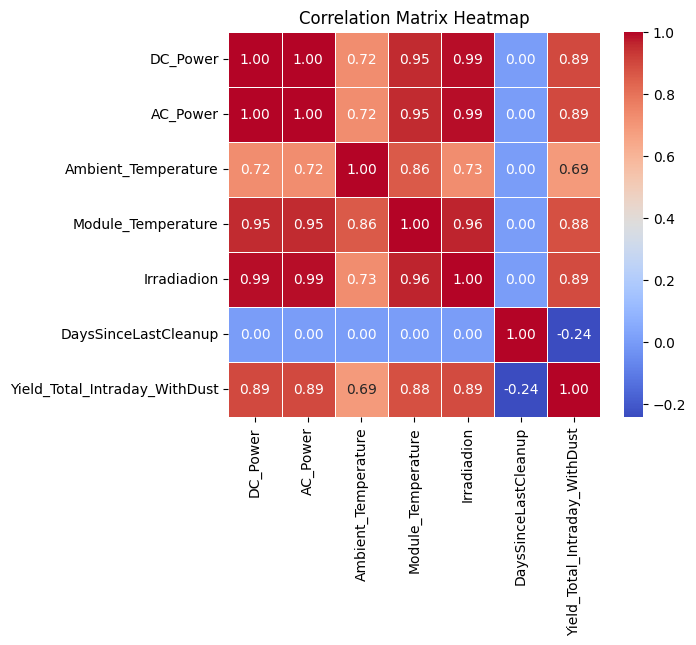

In [4]:
# find the correlation between numerical features. 
# The aim is to reduce the volume of data used by the ML training

df_corr = raw_data[['DC_Power', 'AC_Power', 'Ambient_Temperature', 'Module_Temperature', 'Irradiadion', 'DaysSinceLastCleanup', 'Yield_Total_Intraday_WithDust']]
correlation_matrix = df_corr.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()



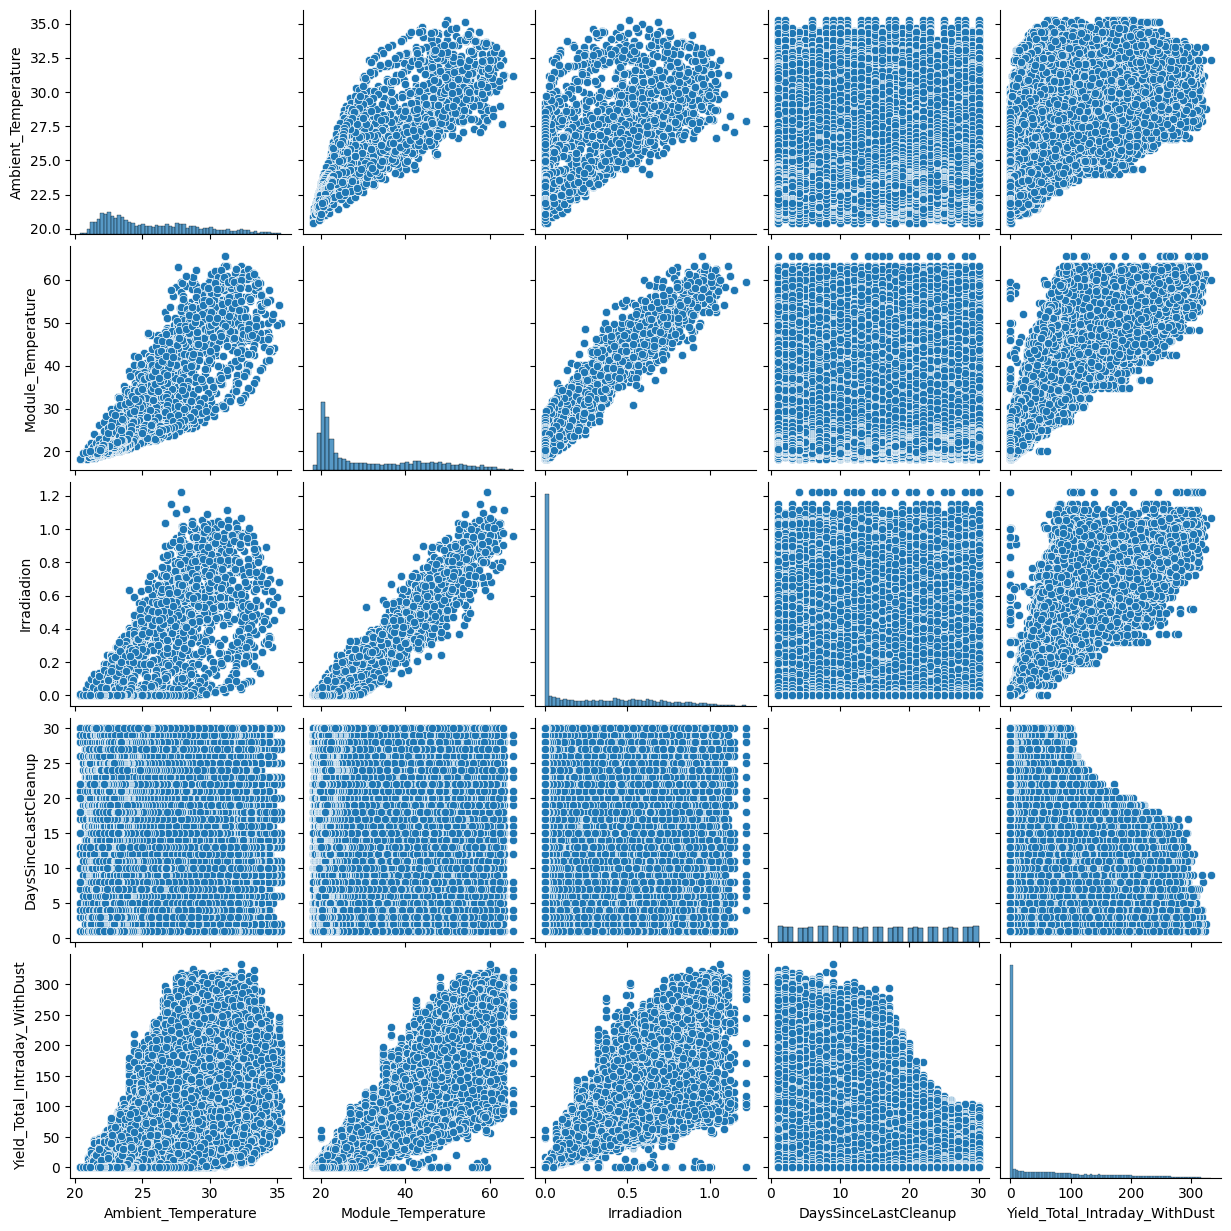

In [5]:
# keep the relevant columns for our calculations
# AC Power and DC power have been ignored as these are strongly correlated to Irradiation
# just keeping Irradiation will be fine, we also reducing the pressure on CPU during training

df_ML = raw_data[['Ambient_Temperature','Module_Temperature','Irradiadion','DaysSinceLastCleanup','Yield_Total_Intraday_WithDust']]

# Create a pairplot (scatter matrix)
sns.pairplot(df_ML)
plt.show()

**Data needs to be scaled**

In [19]:
# shuffle data before splitting
df_ML_shuffled = df_ML.sample(frac=1).reset_index(drop=True)

In [20]:
import joblib

scaler_X = MinMaxScaler()
df_ML_Scaled_X = scaler_X.fit_transform(df_ML_shuffled[['Ambient_Temperature','Module_Temperature','Irradiadion','DaysSinceLastCleanup']])
df_ML_Scaled_X

scaler_y = MinMaxScaler()
df_ML_Scaled_y = scaler_y.fit_transform(df_ML_shuffled[['Yield_Total_Intraday_WithDust']])
df_ML_Scaled_y

# Save the scaler for future use, then converting back scaled values to real values
joblib.dump(scaler_X, './models/scaler_X.joblib')
joblib.dump(scaler_y, './models/scaler_y.joblib')

['./models/scaler_y.joblib']

In [21]:
df_ML_Scaled = np.concatenate((df_ML_Scaled_X,df_ML_Scaled_y),axis=1)

**Dataset Split Function**

In [22]:
def split_dataset(data, 
                  train_size=0.7, 
                  test_size=0.3, 
                  random_state=None):
    """
    Splits the dataset into training, test, and validation subsets.

    Parameters:
        data (array-like): The dataset to be split.
        train_size (float): Proportion of the dataset for training.
        test_size (float): Proportion of the dataset for testing.
        random_state (int, optional): Seed for reproducibility.

    Returns:
        tuple: (train_data, test_data)
    """
    assert train_size + test_size == 1, "Sizes must sum to 1."
    
    train_data, test_data = train_test_split(data, train_size=train_size, random_state=random_state)
    
    return train_data, test_data

train_data, test_data = split_dataset(df_ML_Scaled, random_state=42)

print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")

Train size: 48065, Test size: 20600


**Finally, the working datasets**
- Train
- Test

In [23]:
X_train = train_data[:, :-1] # select all columns but the last one
y_train = train_data[:,-1]   # select last column only

X_test = test_data[:, :-1]   # select all columns but the last one
y_test = test_data[:,-1]     # select last column only

Compare the Training data with Test data. We need to observe the distribution which we want to be roughly the same.

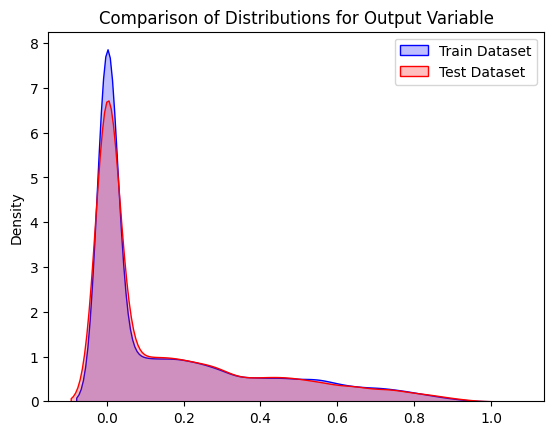

In [11]:
# compare the Output variable distribution
sns.kdeplot(y_train, label="Train Dataset", color="blue", fill = True)
sns.kdeplot(y_test,  label="Test Dataset",  color="red",  fill = True)

plt.legend()
plt.title("Comparison of Distributions for Output Variable")
plt.show()


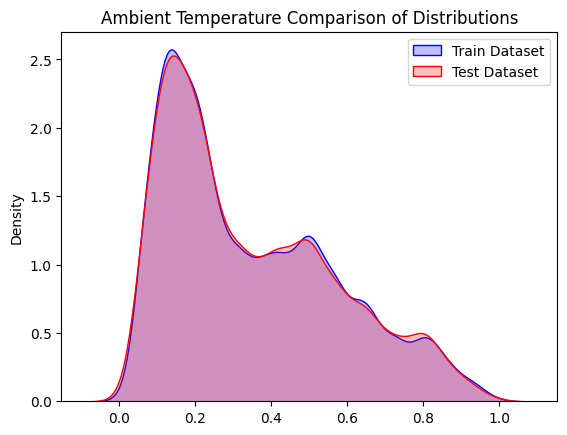

In [12]:
# Ambient temperature
sns.kdeplot(X_train[:,0], label="Train Dataset", color="blue", fill = True)
sns.kdeplot(X_test[:,0],  label="Test Dataset",  color="red",  fill = True)

plt.legend()
plt.title("Ambient Temperature Comparison of Distributions")
plt.show()

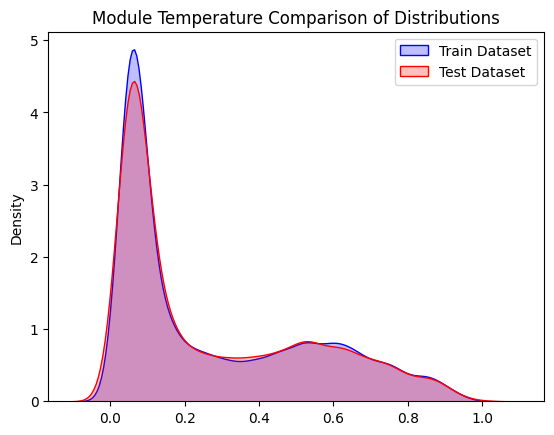

In [13]:
# Module Temperature
sns.kdeplot(X_train[:,1], label="Train Dataset", color="blue", fill = True)
sns.kdeplot(X_test[:,1],  label="Test Dataset",  color="red",  fill = True)

plt.legend()
plt.title("Module Temperature Comparison of Distributions")
plt.show()

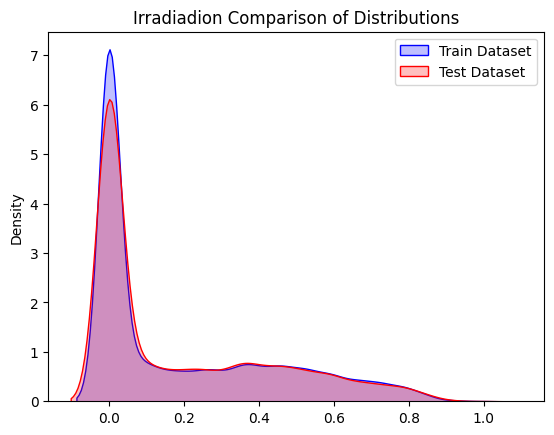

In [14]:
# Irradiation
sns.kdeplot(X_train[:,2], label="Train Dataset", color="blue", fill = True)
sns.kdeplot(X_test[:,2],  label="Test Dataset",  color="red",  fill = True)

plt.legend()
plt.title("Irradiadion Comparison of Distributions")
plt.show()

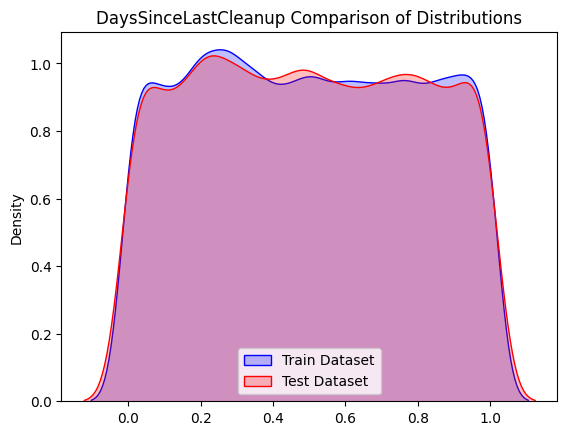

In [15]:
# Days since last cleanup
sns.kdeplot(X_train[:,3], label="Train Dataset", color="blue", fill = True)
sns.kdeplot(X_test[:,3],  label="Test Dataset",  color="red",  fill = True)

plt.legend()
plt.title("DaysSinceLastCleanup Comparison of Distributions")
plt.show()

**Conclusion**
- data in both Training an Test are fairly distributed
- we don't necessarly need to run cross validation

**Polynomial Linear Regression**  
We'll run for the model for various parameters.  
The results will be ploted for visual inspection. 

Create a generous list of polynomial orders. These are the hyperparameters for the model.

In [24]:
orders = list(range(1, 13))
print(orders)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


**Run Training and Prediction for polynomials**  
- We'll train the model 12 times using the Train Data, one for each polynomial order
- Then we'll predict against validation data, 12 times, one for each polynomial order
- For every run we'll save the RMSE then plot the results

In [25]:
training_RMSEs = []
test_RMSEs = []


for ord in orders:
    # Polynomial feature transformation
    poly = PolynomialFeatures(degree=ord)
    X_train_poly = poly.fit_transform(X_train)

    # Training the polynomial regression model
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    # Predictions on train data
    y_train_pred = model_poly.predict(X_train_poly)

    meanSquaredError = ((y_train_pred - y_train) ** 2).mean()
    rmse = np.sqrt(meanSquaredError)
    training_RMSEs.append(rmse)

print(training_RMSEs)

for ord in orders:
    # Polynomial feature transformation
    poly = PolynomialFeatures(degree=ord)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Training the polynomial regression model
    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    # Predictions on test data
    y_pred_test = model_poly.predict(X_test_poly)

    meanSquaredError = ((y_pred_test - y_test) ** 2).mean()
    rmse = np.sqrt(meanSquaredError)
    test_RMSEs.append(rmse)

print(test_RMSEs)

[np.float64(0.08484693378795738), np.float64(0.04447353471432054), np.float64(0.0402185233577646), np.float64(0.03783662985888027), np.float64(0.035812701211447535), np.float64(0.035059927027649346), np.float64(0.03421279702517765), np.float64(0.0336858858800717), np.float64(0.03293055307828199), np.float64(0.03216770439558505), np.float64(0.03157978259626575), np.float64(0.030805876359893722)]
[np.float64(0.08423571521113114), np.float64(0.04532955652740381), np.float64(0.04071668296958165), np.float64(0.038528064015700705), np.float64(0.03689636039490361), np.float64(0.03633756639573868), np.float64(0.0355825894904464), np.float64(0.03530627317627912), np.float64(0.03487037516469064), np.float64(0.03447281193482964), np.float64(0.03439976963472338), np.float64(0.03578249823574536)]


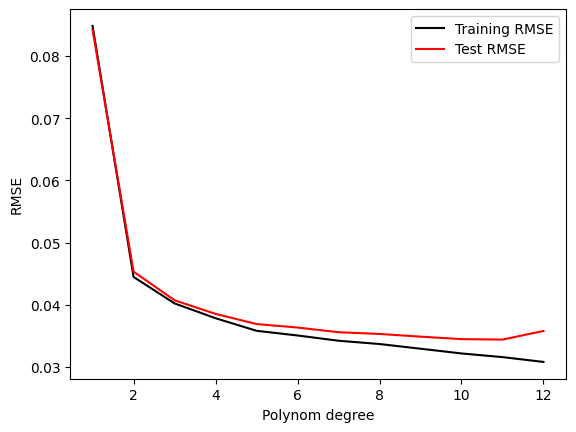

In [26]:
#Plot the training and test RMSEs of the models

x = orders
y_RMSE_Train = training_RMSEs
y_RMSE_Test = test_RMSEs
plt.plot(x, y_RMSE_Train, color='black', label = 'Training RMSE')
plt.plot(x, y_RMSE_Test,  color='red',   label = 'Test RMSE')
plt.xlabel("Polynom degree")
plt.ylabel("RMSE")
plt.legend()

In [27]:
# around Order = 5 we observe best performance on Polynomial Regression
print(y_RMSE_Test[4])

0.03689636039490361


**Conlusion on Polynomial linear regression**  
- after Ord = 5 the RMSE is diverging but still maintaining a downwards direction. It depends on the sample selected by the randoom split.
- after Ord = 10 the RMSE on testing data is degrading, this is expected as the Training data keeps overfitting

**Create a dataframe to save results from all our experiments**

In [28]:
df_results = pd.DataFrame(columns=["ML Model", "Tuning", "RMSE", "Hyperparameter tuning time"])

In [29]:
def save_results_table(df: pd.DataFrame, ML_model: str, Hyperparam_opt: str, RMSE_best: float, exec_time: str, index_position: int):
    #add row
    df.loc[index_position] = [ML_model, Hyperparam_opt, RMSE_best, exec_time]
    df = df.sort_values(by="RMSE", ascending=True)

    # Apply styling
    styled_table = df.style.set_table_styles([{'selector': 'tbody tr', 'props': [('background-color', "#B5F39F")]}]).set_properties(**{'text-align': 'center'})

    # Display
    return styled_table

In [30]:
save_results_table(df_results, 'Polynomial', 'Order 5', y_RMSE_Test[4], "1:30", 0)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
0,Polynomial,Order 5,0.036896,1:30


**Create a function to plot Residual values between Predicted and Actual values of test dataset**

In [31]:
def plot_residuals(actual_values: np.array, predicted_values: np.array, title: str)-> None:

    # Calculate residuals
    residuals = [actual - pred for actual, pred in zip(actual_values, predicted_values)]

    # Create residual plot
    plt.figure(figsize=(8, 5))
    sns.residplot(x=predicted_values, y=residuals, lowess=True, line_kws={"color": "red"})
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(title)
    plt.axhline(y=0, color="black", linestyle="--")  # Reference line
    plt.show()


**Gradient Boost Regresor**

There are two methods(bellow) used to fine tune the hyperparameters

1. Grid Search - provide a number of hard coded values which will be run in all combinations. The best set of parametes will be identified and reported

2. Bayesian Optimisation - the range of parameters will be scanned and played using a more intelligent and efficient way 

In [32]:
# Gradient Boosting Regressor - with Grid Search
# It takes 25 min to run on an average desktop computer

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [30,50,100,150,200],
    'max_depth': [2, 3, 4, 5, 6]
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# Convert results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns
table = results_df[['param_learning_rate', 'param_n_estimators', 'param_max_depth', 'mean_test_score']]

# Rename columns for clarity
table.columns = ['Learning Rate', 'Number of Estimators', 'Max Depth', 'Mean Test Score']

# Display table
print(table)

Best parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 150}
     Learning Rate  Number of Estimators  Max Depth  Mean Test Score
0             0.01                    30          2        -0.031573
1             0.01                    50          2        -0.023079
2             0.01                   100          2        -0.011329
3             0.01                   150          2        -0.006326
4             0.01                   200          2        -0.004191
..             ...                   ...        ...              ...
120           0.30                    30          6        -0.001015
121           0.30                    50          6        -0.000940
122           0.30                   100          6        -0.000891
123           0.30                   150          6        -0.000889
124           0.30                   200          6        -0.000923

[125 rows x 4 columns]


Calculate Root Mean Square Error for best parameters from GridSearch against Test data

In [33]:
# Initialize and train the Gradient Boosting Regressor using best parameters from Grid Search
gbm_GridSearch = GradientBoostingRegressor(n_estimators  = grid_search.best_params_["n_estimators"], 
                                           learning_rate = grid_search.best_params_["learning_rate"], 
                                           max_depth     = grid_search.best_params_["max_depth"], 
                                           random_state  = 42)
gbm_GridSearch.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm_GridSearch.predict(X_test)

# Evaluate the model
meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_GBR_GridSearch = np.sqrt(meanSquaredError)

print(f"Root Mean Squared Error: {rmse_GBR_GridSearch}")

Root Mean Squared Error: 0.028623168118150955


In [34]:
save_results_table(df_results,'Gradient Boosting Regressor', 'Grid Search', rmse_GBR_GridSearch, '25:00', 1)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
0,Polynomial,Order 5,0.036896,1:30


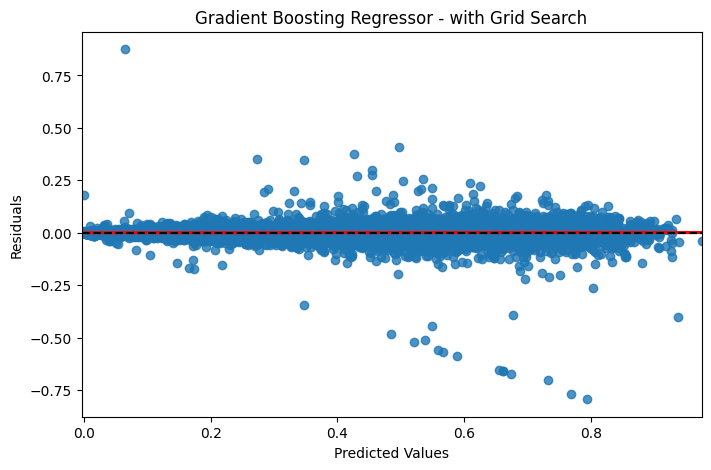

In [35]:
plot_residuals(y_test, y_pred, "Gradient Boosting Regressor - with Grid Search")

In [36]:
## Gradient Boosting Regressor -  Bayesian Optimisation with a mix of continous and discrete values
# it takes 5 min to run
# lets call this Bayesian Optimisation A

search_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),        # this is a continous interval
    'n_estimators': hp.choice('n_estimators', [30,50,100,150,200]), # this is a discrete list of integers
    'max_depth': hp.choice('max_depth', [2, 3, 4, 5, 6])            # this is a discrete list of integers
}


# Objective function
def objective(params):
    model = GradientBoostingRegressor(
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=42
    )
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return -score  # Minimize negative MSE

# Run optimization
trials = Trials()
best_params_gauss = fmin(fn=objective, space=search_space, algo=tpe.suggest, max_evals=20, trials=trials)

# Display best parameters
print(f"Best parameters: {best_params_gauss}")

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 20/20 [05:01<00:00, 15.08s/trial, best loss: 0.0008440886554913794]
Best parameters: {'learning_rate': np.float64(0.20666286337890422), 'max_depth': np.int64(4), 'n_estimators': np.int64(3)}


In [37]:
from typing import Literal

print(f"Best parameters: {best_params_gauss}")
print(f"Best parameters learning rate: {best_params_gauss['learning_rate']}")
print(f"Best parameters n_estimators: {search_space['n_estimators'].pos_args[best_params_gauss['n_estimators']].obj}")
print(f"Best parameters max_depth: {search_space['max_depth'].pos_args[best_params_gauss['max_depth']].obj}")


Best parameters: {'learning_rate': np.float64(0.20666286337890422), 'max_depth': np.int64(4), 'n_estimators': np.int64(3)}
Best parameters learning rate: 0.20666286337890422
Best parameters n_estimators: 100
Best parameters max_depth: 5


In [38]:
# use these parameters to calculate the RSME

# Initialize and train the Gradient Boosting Regressor using best parameters from Bayesian Optimisation A
gbm_BayesianOptA = GradientBoostingRegressor(n_estimators= search_space['n_estimators'].pos_args[best_params_gauss['n_estimators']].obj, 
                                           learning_rate = best_params_gauss['learning_rate'], 
                                           max_depth     = search_space['max_depth'].pos_args[best_params_gauss['max_depth']].obj, 
                                           random_state  = 42)
gbm_BayesianOptA.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm_BayesianOptA.predict(X_test)

# Evaluate the model
meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_BayesianOptA = np.sqrt(meanSquaredError)

print(f"Root Mean Squared Error: {rmse_BayesianOptA}")

Root Mean Squared Error: 0.03023248710174443


In [39]:
save_results_table(df_results,'Gradient Boosting Regressor', 'Bayesian Optimisation A', rmse_BayesianOptA, '4:30', 2)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
2,Gradient Boosting Regressor,Bayesian Optimisation A,0.030232,4:30
0,Polynomial,Order 5,0.036896,1:30


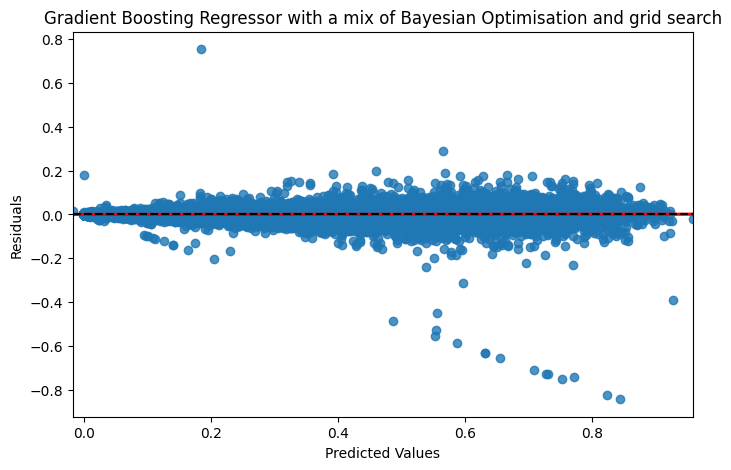

In [40]:
plot_residuals(y_test, y_pred, "Gradient Boosting Regressor with a mix of Bayesian Optimisation and grid search")

In [41]:
# this is another method of hyperparameters Bayesian Optimisation where all possible values are located within continous intervals
# let's call this Bayesia Optimisation B

from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# Define the model
gb_regressor = GradientBoostingRegressor()

# Define the search space
search_space = {
    'n_estimators': (30, 200),    # this is a continous interval
    'learning_rate': (0.01, 0.3), # this is a continous interval
    'max_depth': (2, 6)           # this is a continous interval of integers
}

# Perform Bayesian Search
bayesOptB = BayesSearchCV(gb_regressor, search_space, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs = 1)
bayesOptB.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", bayesOptB.best_params_)

Best hyperparameters: OrderedDict([('learning_rate', 0.18895996992212702), ('max_depth', 6), ('n_estimators', 153)])


Calculate Root Mean Square Error for best parameters from Bayesian Optimisation against Test data

In [42]:
# Initialize and train the Gradient Boosting Regressor using best parameters from Bayesian Optimisation
gbm_BayesOptB = GradientBoostingRegressor(n_estimators   = bayesOptB.best_params_['n_estimators'], 
                                           learning_rate = bayesOptB.best_params_['learning_rate'], 
                                           max_depth     = bayesOptB.best_params_['max_depth'], 
                                           random_state  = 42)
gbm_BayesOptB.fit(X_train, y_train)

# Predict on the test set
y_pred = gbm_BayesOptB.predict(X_test)

# Evaluate the model
meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_BayesOptB = np.sqrt(meanSquaredError)

print(f"Root Mean Squared Error: {rmse_BayesOptB}")

Root Mean Squared Error: 0.02869044441303236


In [43]:
save_results_table(df_results,'Gradient Boosting Regressor', 'Bayesia Optimisation B', rmse_BayesOptB, '5:30', 3)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
3,Gradient Boosting Regressor,Bayesia Optimisation B,0.028690,5:30
2,Gradient Boosting Regressor,Bayesian Optimisation A,0.030232,4:30
0,Polynomial,Order 5,0.036896,1:30


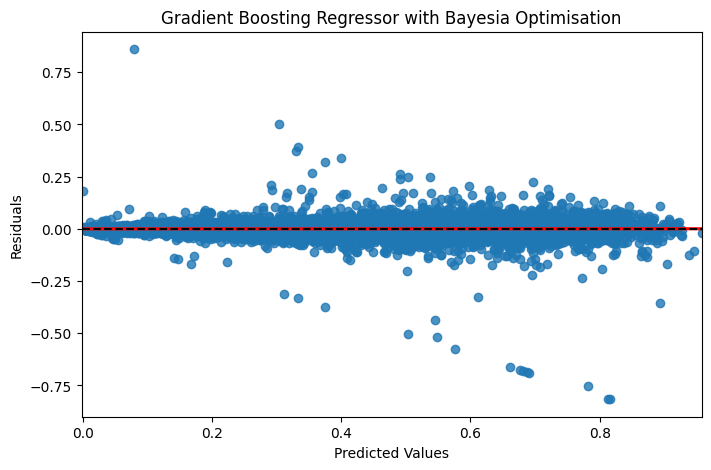

In [44]:
plot_residuals(y_test, y_pred, "Gradient Boosting Regressor with Bayesia Optimisation")

**Conclusion**
- Bayesian Optimisation is much faster and the result is satisfactory.
- Grid Search can deliver good results if the search is done within the right range, the downside is compute resources

**Random Forest Regressor**  
- Run the model for a number on hyperparameters using GridSearch.
- Run the model using RandomizeSearch 
- Run the model using Bayesian Optimisation
- In both cases will calculate the RMSE using the best parameters

In [46]:
# RANDOM FOREST

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [47]:

# Grid Search
# Initialize the model
rf = RandomForestRegressor(random_state=42)

# Perform Grid Search
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Display best parameters
print(f"Best Parameters: {grid_search_rf.best_params_}")

# Convert results to DataFrame
results_df = pd.DataFrame(grid_search_rf.cv_results_)

# Select relevant columns
table = results_df[['param_n_estimators', 
                    'param_max_depth', 
                    'param_min_samples_split', 
                    'param_min_samples_leaf', 
                    'param_max_features',
                    'mean_test_score']]

# Rename columns for clarity
table.columns = ['estimators Rate', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features', 'mean_test_score']

# Display table
print(table)

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
     estimators Rate max_depth  min_samples_split  min_samples_leaf  \
0                100         5                  5                 1   
1                200         5                  5                 1   
2                100         5                 10                 1   
3                200         5                 10                 1   
4                100         5                  5                 2   
..               ...       ...                ...               ...   
103              200      None                 10                 2   
104              100      None                  5                 4   
105              200      None                  5                 4   
106              100      None                 10                 4   
107              200      None                 10                 4   

    max_features  

In [48]:
from sklearn.model_selection import RandomizedSearchCV

# Use a randomized search with a limited number of evaluations
random_search = RandomizedSearchCV(rf, param_grid, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}


Root Mean Squared Error Search Grid: 0.028995147000827434


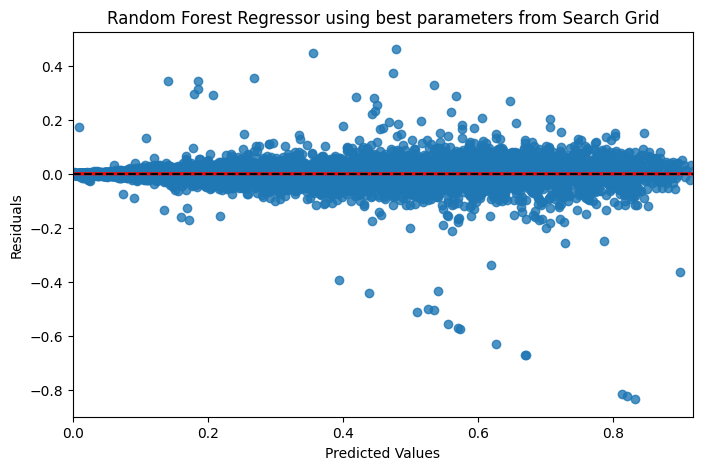

Root Mean Squared Error Random Search: 0.029113145736170236


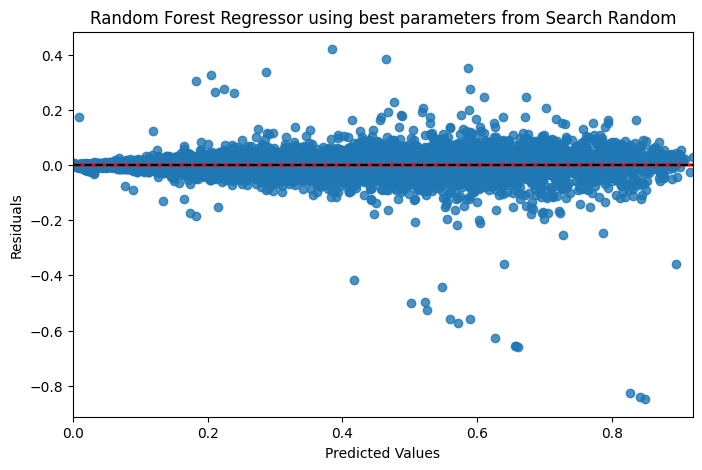

In [49]:
# Initialize and train the Random Forest Regressor using best parameters from Search Grid
rf = RandomForestRegressor(n_estimators      = grid_search_rf.best_params_["n_estimators"], 
                           max_depth         = grid_search_rf.best_params_["max_depth"], 
                           min_samples_leaf  = grid_search_rf.best_params_["min_samples_leaf"], 
                           min_samples_split = grid_search_rf.best_params_["min_samples_split"], 
                           max_features      = grid_search_rf.best_params_["max_features"], 
                           random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)


# Evaluate the model
meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_searchGrid = np.sqrt(meanSquaredError)

print(f"Root Mean Squared Error Search Grid: {rmse_searchGrid}")

plot_residuals(y_test, y_pred, "Random Forest Regressor using best parameters from Search Grid")

# Initialize and train the Random Forest Regressor using best parameters from Search Random
rf = RandomForestRegressor(n_estimators      = random_search.best_params_["n_estimators"], 
                           max_depth         = random_search.best_params_["max_depth"], 
                           min_samples_leaf  = random_search.best_params_["min_samples_leaf"], 
                           min_samples_split = random_search.best_params_["min_samples_split"], 
                           max_features      = random_search.best_params_["max_features"], 
                           random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)


# Evaluate the model
meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_searchRandom = np.sqrt(meanSquaredError)

print(f"Root Mean Squared Error Random Search: {rmse_searchRandom}")

plot_residuals(y_test, y_pred, "Random Forest Regressor using best parameters from Search Random")

In [50]:
save_results_table(df_results,'RandomForestRegressor', 'Grid Search',      rmse_searchGrid,   '5:30', 4)

save_results_table(df_results,'RandomForestRegressor', 'RandomizedSearch', rmse_searchRandom, '1:00', 5)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
3,Gradient Boosting Regressor,Bayesia Optimisation B,0.028690,5:30
4,RandomForestRegressor,Grid Search,0.028995,5:30
5,RandomForestRegressor,RandomizedSearch,0.029113,1:00
2,Gradient Boosting Regressor,Bayesian Optimisation A,0.030232,4:30
0,Polynomial,Order 5,0.036896,1:30


**RandomForestRegressor - Bayesian Optimisation**

In [51]:

# Define the function to optimize
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features):
    """Cross-validation function for Bayesian Optimization"""
    model = RandomForestRegressor(
        n_estimators      = int(n_estimators),       # Must be an integer
        max_depth         = int(max_depth),          # Must be an integer
        min_samples_split = int(min_samples_split),  # Must be an integer
        min_samples_leaf  = int(min_samples_leaf),   # Must be an integer
        max_features      = max_features,            # Can be float or categorical
        random_state      = 42,
        n_jobs            = -1
    )
    
    # Use cross-validation to evaluate performance
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)  # Bayesian Optimization maximizes, so we return negative MSE

# Define the hyperparameter search space
param_bounds = {
    'n_estimators': (50, 200),     # Number of trees
    'max_depth': (5, 30),          # Maximum depth of trees
    'min_samples_split': (2, 10),  # Minimum samples required to split a node
    'min_samples_leaf': (1, 5),    # Minimum samples required at a leaf node
    'max_features': (0.1, 1.0)     # Fraction of features to consider for best split
}

# Perform Bayesian Optimization
optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=20)

# Get the best parameters
best_params = optimizer.max['params']
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['min_samples_split'] = int(best_params['min_samples_split'])
best_params['min_samples_leaf'] = int(best_params['min_samples_leaf'])

print("Best Hyperparameters:", best_params)

# Train the best model
best_model_rf_bayes = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model_rf_bayes.fit(X_train, y_train)

# Evaluate on test data
y_pred = best_model_rf_bayes.predict(X_test)
rmse_rf_bayes = np.sqrt(np.mean((y_test - y_pred) ** 2))
print("Test RMSE:", rmse_rf_bayes)


save_results_table(df_results,'RandomForestRegressor', 'Bayesian Optimisation',      rmse_rf_bayes,   '1:00', 6)


|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -0.000913 | 14.36     | 0.9556    | 3.928     | 6.789     | 73.4      |
| 2         | -0.001555 | 8.9       | 0.1523    | 4.465     | 6.809     | 156.2     |
| 3         | -0.00178  | 5.515     | 0.9729    | 4.33      | 3.699     | 77.27     |
| 4         | -0.001359 | 9.585     | 0.3738    | 3.099     | 5.456     | 93.68     |
| 5         | -0.000844 | 20.3      | 0.2255    | 2.169     | 4.931     | 118.4     |
| 6         | -0.000886 | 14.68     | 0.722     | 2.032     | 8.656     | 141.5     |
| 7         | -0.000858 | 27.66     | 0.1948    | 1.589     | 9.402     | 165.6     |
| 8         | -0.000873 | 19.6      | 0.143     | 1.143     | 2.836     | 84.98     |
| 9         | -0.000903 | 16.71     | 0.9937    | 4.687     | 5.455     | 97.33     |
| 10        | -0.000836 | 25.19     | 0.2582    | 2.26

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
3,Gradient Boosting Regressor,Bayesia Optimisation B,0.028690,5:30
4,RandomForestRegressor,Grid Search,0.028995,5:30
5,RandomForestRegressor,RandomizedSearch,0.029113,1:00
6,RandomForestRegressor,Bayesian Optimisation,0.029293,1:00
2,Gradient Boosting Regressor,Bayesian Optimisation A,0.030232,4:30
0,Polynomial,Order 5,0.036896,1:30


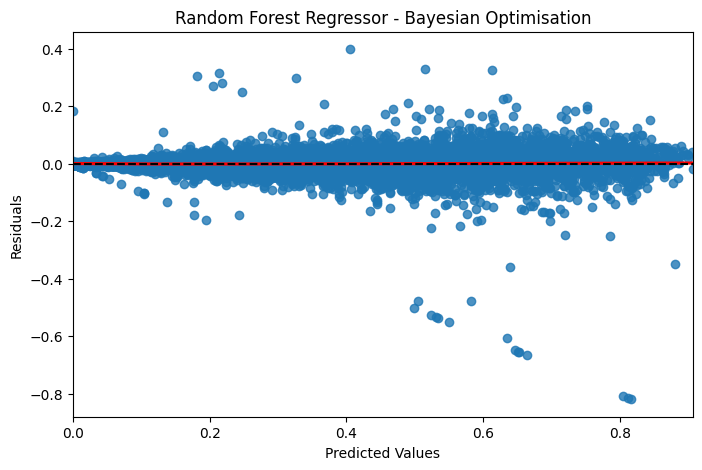

In [52]:
plot_residuals(y_test, y_pred, "Random Forest Regressor - Bayesian Optimisation")

**KNN**

In [53]:

# Define the model
knn = KNeighborsRegressor()

# Define the parameter search space
param_space = {
    "n_neighbors": (1, 20),             # Number of neighbors
    "weights": ["uniform", "distance"], # Weighting strategy
    "p": (1, 2)                         # Distance metric (1: Manhattan, 2: Euclidean)
}

# Set up Bayesian Optimization with cross-validation
bayes_search_knn = BayesSearchCV(
    knn, 
    param_space, 
    n_iter=30,       # Number of optimization iterations
    cv=5,            # Cross-validation folds
    n_jobs=1,        # Use 1 CPU core
    random_state=42
)

# Fit the optimizer
bayes_search_knn.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", bayes_search_knn.best_params_)
print("Best score:", bayes_search_knn.best_score_)

Best parameters: OrderedDict([('n_neighbors', 15), ('p', 1), ('weights', 'distance')])
Best score: 0.977240401121912


In [54]:
# Initialize KNN regressor with a chosen number of neighbors (e.g., 5)
knn = KNeighborsRegressor(n_neighbors = bayes_search_knn.best_params_['n_neighbors'],
                          p           = bayes_search_knn.best_params_['p'],
                          weights     = bayes_search_knn.best_params_['weights'])
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


meanSquaredError = ((y_pred - y_test) ** 2).mean()
rmse_knn = np.sqrt(meanSquaredError)

print(f'Root Mean Squared Error: {rmse_knn}')

Mean Squared Error: 0.0012515164093062521
Root Mean Squared Error: 0.03537677782537935


In [55]:
save_results_table(df_results, 'KNeighborsRegressor', 'Bayesian Optimisation',      rmse_knn,   '0:30', 7)

,ML Model,Tuning,RMSE,Hyperparameter tuning time
1,Gradient Boosting Regressor,Grid Search,0.028623,25:00
3,Gradient Boosting Regressor,Bayesia Optimisation B,0.028690,5:30
4,RandomForestRegressor,Grid Search,0.028995,5:30
5,RandomForestRegressor,RandomizedSearch,0.029113,1:00
6,RandomForestRegressor,Bayesian Optimisation,0.029293,1:00
2,Gradient Boosting Regressor,Bayesian Optimisation A,0.030232,4:30
7,KNeighborsRegressor,Bayesian Optimisation,0.035377,0:30
0,Polynomial,Order 5,0.036896,1:30


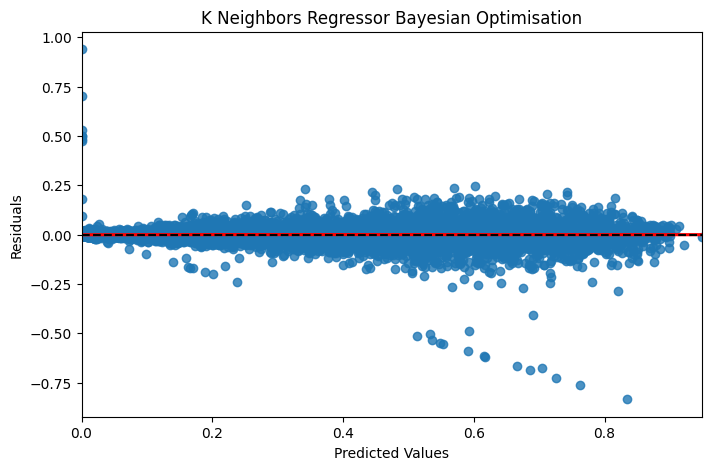

In [56]:
plot_residuals(y_test, y_pred, "K Neighbors Regressor Bayesian Optimisation")

**Save the best Model**
- Random Forest Regressor - Bayesian Optimisation for Hyperparameter tuning 

In [ ]:
import pickle

# save model using pickle
with open('./models/best_model_rf_bayes_model.pkl','wb') as file:
    pickle.dump(best_model_rf_bayes,file)
    

**Select random 200 records from original data**
- show how to use the model

In [52]:
new_data = raw_data[['Ambient_Temperature','Module_Temperature','Irradiadion','DaysSinceLastCleanup','Yield_Total_Intraday_WithDust']].sample(n=200, random_state=42)
X_new    = new_data[['Ambient_Temperature','Module_Temperature','Irradiadion','DaysSinceLastCleanup']]

# use this in case of back testing
y_new = new_data[['Yield_Total_Intraday_WithDust']]


# Load model
with open('./models/best_model_rf_bayes_model.pkl', 'rb') as file:
    model_pickled = pickle.load(file)

# Load the scalers
scaler_X_saved = joblib.load('./models/scaler_X.joblib')
scaler_y_saved = joblib.load('./models/scaler_y.joblib')

# Normalize new data (X_new is our new input) using the saved scaler of data used in training
X_new_normalised = scaler_X_saved.transform(X_new)

# Make predictions
predictions_normalised = model_pickled.predict(X_new_normalised)

# get the real prediction numbers by inverse transform using the saved scaler of data used in training
predictions_real = scaler_y_saved.inverse_transform(predictions_normalised.reshape(-1, 1))

print(predictions_real)


[[1.61700752e+01]
 [1.37494081e+02]
 [2.36101496e+02]
 [5.78221684e-02]
 [1.07599651e+02]
 [1.78405546e+02]
 [7.74035200e+01]
 [1.07010495e+02]
 [4.25574374e+01]
 [2.12908709e+02]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.80256991e+01]
 [1.45905624e+01]
 [2.98205809e-03]
 [2.31025896e-04]
 [1.67981511e+02]
 [2.75938983e+02]
 [7.90952322e+01]
 [3.48828296e-02]
 [4.33567839e+01]
 [2.54191049e-03]
 [9.71792485e-01]
 [3.46352810e-06]
 [4.51662833e+01]
 [9.53904742e+01]
 [1.08378489e-02]
 [4.60708272e-02]
 [1.89840047e+01]
 [1.05467414e-02]
 [7.01523247e+01]
 [4.24580904e+01]
 [1.19758150e+02]
 [7.90127870e+01]
 [3.15584368e+01]
 [1.01780233e-02]
 [3.21203379e-05]
 [1.35954464e-05]
 [1.74155439e-03]
 [9.57442100e+01]
 [7.26265231e+01]
 [1.67503228e-02]
 [5.36844959e-02]
 [1.38931769e-04]
 [6.62489602e+01]
 [5.92198922e-02]
 [2.26148591e+01]
 [0.00000000e+00]
 [1.41331726e-04]
 [5.54814635e+01]
 [1.90168746e-02]
 [4.65091139e-02]
 [3.46352810e-06]
 [2.33930380e-03]
 [1.04070319e+01]
 [1.811702